In [7]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Proprocessing
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# XGBoost Model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import optuna
from sklearn.ensemble import RandomForestRegressor

# For reproducibility
from teachopencadd.utils import seed_everything
SEED = 42
seed_everything(SEED)

In [8]:
train_file_path_scat = '../Data/Data/train_filter_scat.csv'
train_df_scat = pd.read_csv(train_file_path_scat)

train_file_path_UMAP = '../Data/Data/train_filter_UMAP.csv'
train_df_UMAP = pd.read_csv(train_file_path_UMAP)

# Pipelines

In [9]:
ode_cols = ['LotShape', 'LandContour', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC']
ohe_cols = ['MSZoning', 'Street', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'SaleType', 'SaleCondition']
num_cols = train_df_UMAP.select_dtypes(include=['float64', 'int64']).columns
num_cols = num_cols.drop("SalePrice")

In [10]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))

])

col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ode_cols),
    ('ohe_p', ohe_pipeline, ohe_cols),
    ],
    remainder='passthrough',
    n_jobs=-1)

pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [11]:
# X = train_df_UMAP.drop('SalePrice', axis=1)
# Y = train_df_UMAP['SalePrice']

# # Pass the data through the pipeline
# X_preprocessed = pipeline.fit_transform(X)

# # Train test split
# x_train_UMAP, x_test_UMAP, y_train_UMAP, y_test_UMAP= train_test_split(X_preprocessed, Y, test_size=0.2, random_state=SEED)

X = train_df_scat.drop('SalePrice', axis=1)
Y = train_df_scat['SalePrice']

# Pass the data through the pipeline
X_preprocessed = pipeline.fit_transform(X)

# Train test split
x_train_scat, x_test_scat, y_train_scat, y_test_scat= train_test_split(X_preprocessed, Y, test_size=0.2, random_state=SEED)

# Random Forest Regressor

In [12]:
# RF = RandomForestRegressor(random_state=SEED)
# RF.fit(x_train_UMAP , y_train_UMAP)
# y_pred = RF.predict(x_test_UMAP)

RF = RandomForestRegressor(random_state=SEED)
RF.fit(x_train_scat , y_train_scat)
y_pred = RF.predict(x_test_scat)

In [13]:
# scatter plot of predicted vs actual
plt.figure(figsize=(10, 10))
plt.scatter(y_test_scat, y_pred)
plt.plot(range(0, 600000), range(0, 600000), color='red')
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Default RF model: Scatter Filter")
plt.show()

pearson_corr, _ = stats.pearsonr(y_test_scat, y_pred)
spearman_corr, _ = stats.spearmanr(y_test_scat, y_pred)
r2 = r2_score(y_test_scat, y_pred)
mae = mean_absolute_error(y_test_scat, y_pred)
rmse = math.sqrt(mean_squared_error(y_test_scat, y_pred))

print(f"R^2: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"Pearson correlation: {pearson_corr:.3f}")
print(f"Spearman correlation: {spearman_corr:.3f}")

NameError: name 'y_test_UMAP' is not defined

<Figure size 1000x1000 with 0 Axes>

In [ ]:
# def objective_UMAP(trial):
#     n_estimators = trial.suggest_int('n_estimators', 100, 750)
#     max_depth = trial.suggest_categorical('max_depth', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None])
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
#     model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=SEED)
#     model.fit(x_train_UMAP, y_train_UMAP)

#     score = cross_val_score(model, x_train_UMAP, y_train_UMAP, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
#     return score

def objective_UMAP(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 750)
    max_depth = trial.suggest_categorical('max_depth', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=SEED)
    model.fit(x_train_scat, y_train_scat)

    score = cross_val_score(model, x_train_scat, y_train_scat, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
    return score



In [ ]:
# study_UMAP_RF = optuna.create_study(direction='maximize', sampler = optuna.samplers.TPESampler(seed=SEED))
# study_UMAP_RF.optimize(objective_UMAP, n_trials=1000, show_progress_bar=True)

study_scat_RF = optuna.create_study(direction='maximize', sampler = optuna.samplers.TPESampler(seed=SEED))
study_scat_RF.optimize(objective_scat, n_trials=1000, show_progress_bar=True)

In [ ]:
study_scat_RF.best_params

# UMAP best
{'n_estimators': 750,
 'max_depth': None,
 'min_samples_split': 8,
 'min_samples_leaf': 1}

In [ ]:
# best_params_UMAP = {'n_estimators': 750,
#  'max_depth': None,
#  'min_samples_split': 8,
#  'min_samples_leaf': 1}
# best_params_UMAP = study_UMAP_RF.best_params

best_params_scat = study_scat_RF.best_params

# best_n_estimators_UMAP = best_params_UMAP['n_estimators']
# best_max_depth_UMAP = best_params_UMAP['max_depth']
# best_min_samples_split_UMAP = best_params_UMAP['min_samples_split']
# best_min_samples_leaf_UMAP = best_params_UMAP['min_samples_leaf']

# best_RF_UMAP = RandomForestRegressor(n_estimators=best_n_estimators_UMAP, max_depth=best_max_depth_UMAP, min_samples_split=best_min_samples_split_UMAP, min_samples_leaf=best_min_samples_leaf_UMAP, random_state=SEED)
# best_RF_UMAP.fit(x_train_UMAP, y_train_UMAP)
# best_y_pred_UMAP = best_RF_UMAP.predict(x_test_UMAP)

best_b_estimators_scat = best_params_scat['n_estimators']
best_max_depth_scat = best_params_scat['max_depth']
best_min_samples_split_scat = best_params_scat['min_samples_split']
best_min_samples_leaf_scat = best_params_scat['min_samples_leaf']

best_RF_scat = RandomForestRegressor(n_estimators=best_n_estimators_scat, max_depth=best_max_depth_scat, min_samples_split=best_min_samples_split_scat, min_samples_leaf=best_min_samples_leaf_scat, random_state=SEED)
best_RF_scat.fit(x_train_scat, y_train_scat)
best_y_pred_scat = best_RF_scat.predict(x_test_scat)

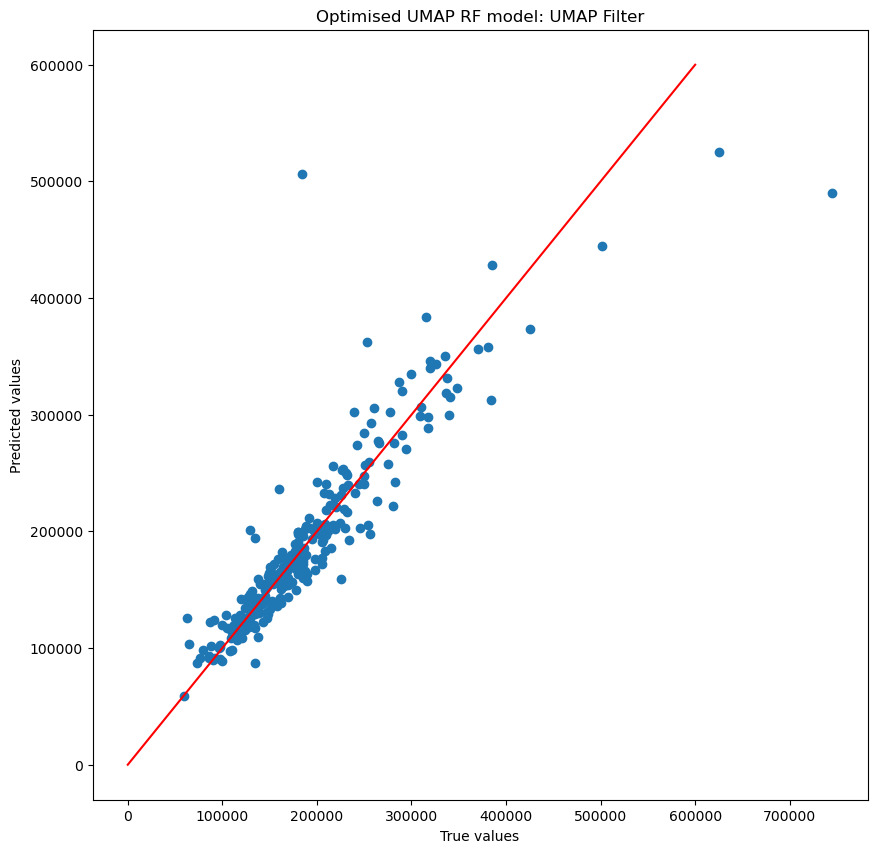

R^2: 0.826
RMSE: 33765.693
MAE: 17811.553
Pearson correlation: 0.909
Spearman correlation: 0.946


In [ ]:
# # scatter plot of predicted vs actual
# plt.figure(figsize=(10, 10))
# plt.scatter(y_test_UMAP, best_y_pred_UMAP)
# plt.plot(range(0, 600000), range(0, 600000), color='red')
# plt.xlabel("True values")
# plt.ylabel("Predicted values")
# plt.title("Optimised UMAP RF model: UMAP Filter")
# plt.show()

# pearson_corr_best_UMAP, _ = stats.pearsonr(y_test_UMAP, best_y_pred_UMAP)
# spearman_corr_best_UMAP, _ = stats.spearmanr(y_test_UMAP, best_y_pred_UMAP)
# r2_best_UMAP = r2_score(y_test_UMAP, best_y_pred_UMAP)
# mae_best_UMAP = mean_absolute_error(y_test_UMAP, best_y_pred_UMAP)
# rmse_best_UMAP = math.sqrt(mean_squared_error(y_test_UMAP, best_y_pred_UMAP))

# print(f"R^2: {r2_best_UMAP:.3f}")
# print(f"RMSE: {rmse_best_UMAP:.3f}")
# print(f"MAE: {mae_best_UMAP:.3f}")
# print(f"Pearson correlation: {pearson_corr_best_UMAP:.3f}")
# print(f"Spearman correlation: {spearman_corr_best_UMAP:.3f}")

plt.figure(figsize=(10, 10))
plt.scatter(y_test_scat, best_y_pred_scat)
plt.plot(range(0, 600000), range(0, 600000), color='red')
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Optimised UMAP RF model: Scatter Filter")
plt.show()

pearson_corr_best_scat, _ = stats.pearsonr(y_test_scat, best_y_pred_scat)
spearman_corr_best_scat, _ = stats.spearmanr(y_test_scat, best_y_pred_scat)
r2_best_scat = r2_score(y_test_scat, best_y_pred_scat)
mae_best_scat = mean_absolute_error(y_test_scat, best_y_pred_scat)
rmse_best_scat = math.sqrt(mean_squared_error(y_test_scat, best_y_pred_scat))

print(f"R^2: {r2_best_scat:.3f}")
print(f"RMSE: {rmse_best_scat:.3f}")
print(f"MAE: {mae_best_scat:.3f}")
print(f"Pearson correlation: {pearson_corr_best_scat:.3f}")
print(f"Spearman correlation: {spearman_corr_best_scat:.3f}")


In [ ]:
# test_file_path = "../Data/Data/Initial Filtering/test_filter.csv"
# test_df = pd.read_csv(test_file_path) #(1459, 66)

# X_preprocessed_sub = pipeline.transform(test_df) 


In [ ]:
# y_pred_sub =  best_RF_UMAP.predict(X_preprocessed_sub)
# y_pred_sub =  best_RF_scat.predict(X_preprocessed_sub)

In [ ]:
# submission = test_df[['Id']]
# submission['SalePrice'] = y_pred_sub

# submission.to_csv("../Data/Data/Submission/submission_RFR.csv", index=False)
# submission.head()

/var/folders/r0/qp6_p2111v1dzb0fg2bbfqsr0000gn/T/ipykernel_24701/3151214707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['SalePrice'] = y_pred_sub


,Id,SalePrice
0,1461,122558.563259
1,1462,161492.044956
2,1463,185811.480123
3,1464,186456.569298
4,1465,191354.628026


# Score = 0.15388